In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import gym

# For algorithms outside of TF/Keras training loops
# it's often faster to disable eager execution...
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

In [2]:
class Maze1D():
    def __init__(self,
                 n_states=10,
                 goal_state=5,
                 reward_nongoal=0.0,
                 reward_goal=1.0):
        """
        These options are paricular to the 1D maze environment/task:
        n_states - size (length) of the 1D maze
        goal_state - where the task terminates (terminal state)
        reward_nongoal - scalar reward for all non-terminal states
        reward_goal - scalar reward for terminal state
        """
        self.n_states = n_states
        self.goal_state = goal_state
        self.reward_nongoal = reward_nongoal
        self.reward_goal = reward_goal
        # Agent's current location (initially nowhere)
        self.x = np.array([-1])
        self.observation_space = np.array([n_states])
        class a: pass
        self.action_space = a()
        self.action_space.n = 2
        
    def reset(self):
        self.x[0] = np.random.randint(self.n_states)
        while self.x[0] == self.goal_state:
            self.x[0] = np.random.randint(self.n_states)
        return np.copy(self.x)
    
    def step(self,action):
        if action:
            self.x = (self.x + 1) % self.n_states
        else:
            self.x = (self.x - 1) % self.n_states
        if self.x[0] == self.goal_state:
            r = self.reward_goal
            d = True
        else:
            r = self.reward_nongoal
            d = False
        return np.copy(self.x), r, d, None

In [3]:
n_states = 20
goal_state = 5
env = Maze1D(n_states=n_states,
             goal_state=goal_state)

In [4]:
env.observation_space

array([20])

In [5]:
env.action_space.n

2

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding (Embedding)       (None, 1, 100)            2000      
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 256)               25856     
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 28,370
Trainable params: 28,370
Non-trainable params: 0
_________________________________________________________________


2022-11-01 13:52:01.249475: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-01 13:52:01.249522: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-01 13:52:01.249561: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-jphillips): /proc/driver/nvidia/version does not exist
2022-11-01 13:52:01.249734: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


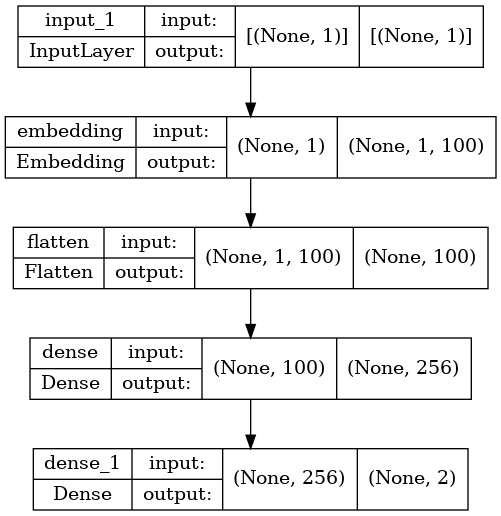

In [6]:
# A simple multilayer architecture....
def make_model(state_shape,
               action_shape,
               state_length = 10,
               embedding_dim = 100,
               hidden_dim = 256):
    """
    The state_shape and action_shape are typical parameters
    that are obtained from the OpenAI gym framework - usually one
    would utilize the env.observation_space.shape and
    env.action_space.n for most situations to set these values,
    respectively.
    
    The remaining keyword arguments are problem-specific and
    may need to be rewritten based on your model architecture.
    For example, here we are using a -discrete- input space for
    the 1DMaze problem - so the input shape is (1,) which can
    be obtained from the variables above for setting state_shape
    appropriately, but the Embedding of those discrete tokens
    (i.e. 0, 1, 2, 3, ..., (n-1)) for each state needs to know
    the maximum number of states (and therefore random vectors)
    to expect in that input vector.
    """
    x = keras.layers.Input(state_shape)
    y = x
    y = keras.layers.Embedding(input_dim=state_length,
                               output_dim=embedding_dim)(y)
    y = keras.layers.Flatten()(y)
    y = keras.layers.Dense(hidden_dim,activation='gelu')(y)
    y = keras.layers.Dense(action_shape)(y)
    model = keras.Model(x,y)
    model.compile(loss=keras.losses.MeanSquaredError(),
                  optimizer=keras.optimizers.Adam(learning_rate=0.001))
    return model

hidden_dim = 256
model = make_model(env.observation_space.shape[0],env.action_space.n,
                   state_length=env.observation_space[0],
                   hidden_dim=hidden_dim)
model.summary()
keras.utils.plot_model(model,show_shapes=True)

In [7]:
Q = model(np.array([[0]]))
Q

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.00110519,  0.0107816 ]], dtype=float32)>

In [8]:
Q.numpy().argmax()

1

In [9]:
# epsilon-greedy policy
epsilon = 0.1
action = np.random.choice([0,1]) if np.random.random() < epsilon else Q.numpy().argmax()
action

1

In [10]:
Q.numpy()

array([[-0.00110519,  0.0107816 ]], dtype=float32)

In [11]:
# Initialize the environment and let the agent decide!
observation = env.reset()
trace = []
epsilon = 0.1
reward = 0.0
for time in range(30):
    Q = model(np.expand_dims(observation,axis=0)) # Compute Q
    action = np.random.choice([0,1]) if np.random.random() < epsilon else Q.numpy().argmax()
    trace.append(np.concatenate([observation,[action],Q[0]]))
    observation, reward, done, info = env.step(action) # take action!
    if (done):
        break
trace.append(np.concatenate([observation,[action],Q[0]]))
# s, a, Q(s,L), Q(s,R)
print(np.vstack(trace))

[[ 9.00000000e+00  0.00000000e+00  2.81596277e-02  2.28659739e-03]
 [ 8.00000000e+00  1.00000000e+00 -2.15416476e-02 -2.01201066e-04]
 [ 9.00000000e+00  0.00000000e+00  2.81596277e-02  2.28659739e-03]
 [ 8.00000000e+00  1.00000000e+00 -2.15416476e-02 -2.01201066e-04]
 [ 9.00000000e+00  0.00000000e+00  2.81596277e-02  2.28659739e-03]
 [ 8.00000000e+00  1.00000000e+00 -2.15416476e-02 -2.01201066e-04]
 [ 9.00000000e+00  0.00000000e+00  2.81596277e-02  2.28659739e-03]
 [ 8.00000000e+00  1.00000000e+00 -2.15416476e-02 -2.01201066e-04]
 [ 9.00000000e+00  0.00000000e+00  2.81596277e-02  2.28659739e-03]
 [ 8.00000000e+00  1.00000000e+00 -2.15416476e-02 -2.01201066e-04]
 [ 9.00000000e+00  0.00000000e+00  2.81596277e-02  2.28659739e-03]
 [ 8.00000000e+00  1.00000000e+00 -2.15416476e-02 -2.01201066e-04]
 [ 9.00000000e+00  0.00000000e+00  2.81596277e-02  2.28659739e-03]
 [ 8.00000000e+00  1.00000000e+00 -2.15416476e-02 -2.01201066e-04]
 [ 9.00000000e+00  0.00000000e+00  2.81596277e-02  2.28659739e

In [12]:
env

In [13]:
# Step 1 - Replay Memory Class
class ReplayMemory:
    def __init__(self, memory_size, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.size = 0
        self.maxsize = memory_size
        self.current_index = 0
        self.current_state = np.zeros([memory_size,env.observation_space.shape[0]])
        self.action = [0]*memory_size # Remember, actions are integers...
        self.reward = np.zeros([memory_size])
        self.next_state = np.zeros([memory_size,env.observation_space.shape[0]])
        self.done = [False]*memory_size # Boolean (terminal transition?)

    def remember(self, current_state, action, reward, next_state, done):
        # Stores a single memory item
        self.current_state[self.current_index,:] = current_state
        self.action[self.current_index] = action
        self.reward[self.current_index] = reward
        self.next_state[self.current_index,:] = next_state
        self.done[self.current_index] = done
        self.current_index = (self.current_index+1)%self.maxsize
        self.size = max(self.current_index,self.size)
    
    def replay(self, model, target_model, num_samples, sample_size, gamma):
        # Run replay!
        
        # Can't train if we don't yet have enough samples to begin with...
        if self.size < sample_size:
            return
        
        for i in range(num_samples):
            # Select sample_size memory indices from the whole set
            current_sample = np.random.choice(self.size,sample_size,replace=False)
            
            # Slice memory into training sample
            current_state = self.current_state[current_sample,:]
            action = [self.action[j] for j in current_sample]
            reward = self.reward[current_sample]
            next_state = self.next_state[current_sample,:]
            done = [self.done[j] for j in current_sample]
            
            # Obtain model's current Q-values
            model_targets = model(current_state).numpy()
            
            # Create targets from argmax(Q(s+1,a+1))
            # Use the target model!
            targets = reward + gamma*np.amax(target_model(next_state).numpy(),axis=1)
            # Absorb the reward on terminal state-action transitions
            targets[done] = reward[done]
            # Update just the relevant parts of the model_target vector...
            model_targets[range(sample_size),action] = targets
            
            # Update the weights accordingly
            model.train_on_batch(current_state,model_targets)
            # model.fit(current_state,model_targets,
            #          epochs=1,verbose=0,batch_size=sample_size)
            
        # Once we have finished training, update the target model
        target_model.set_weights(model.get_weights())

In [14]:
# Full setup for the task...

# For keeping track of performance
from collections import deque

# Hyperparameters
gamma = 0.7
epsilon = 1.0
epsilon_decay = 0.98
epsilon_min = 0.01
episodes = 1000

# Total memory size (number of actions remembered...)
n_memories = 1000

# How many batches do we want to train on
# from the memory before updating the
# target model?
replay_iterations = 10

# How many memories do we use in each batch?
replay_sample_size = 50

# Peformance stats
times_window = deque(maxlen=100)
mean_times = deque(maxlen=episodes)

# Initialize the environment and agent data structures
# env = gym.make('CartPole-v1')
model = make_model(env.observation_space.shape[0],env.action_space.n,
                   state_length=env.observation_space[0])
target_model = make_model(env.observation_space.shape[0],env.action_space.n,
                          state_length=env.observation_space[0])
memory = ReplayMemory(n_memories,env.observation_space.shape[0],env.action_space.n)

In [15]:
memory.current_state[0:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [16]:
memory.next_state[0:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [17]:
memory.action[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [18]:
memory.reward[0:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
memory.done[0:10]

[False, False, False, False, False, False, False, False, False, False]

In [20]:
memory.done==True

False

In [21]:
# Perform the training!
for episode in range(episodes):
    current_state = env.reset()
    for time in range(env.observation_space[0]):
        Q = model(np.expand_dims(current_state,axis=0)) # Compute Q
        action = np.random.choice(env.action_space.n) if np.random.random() < epsilon else Q.numpy().argmax()
        next_state, reward, done, info = env.step(action) # take action!
        memory.remember(current_state,action,reward,next_state,done) # Store in memory...
        current_state = np.copy(next_state) # Transition to next state!
        if (done):
            break
    epsilon = epsilon * epsilon_decay if epsilon > epsilon_min else epsilon_min
    times_window.append(time)
    mean_time = np.mean(times_window)
    mean_times.append(mean_time)
    print('\rEpisode %d/%d - time: %d, mean-time: %d, epsilon: %f'%(episode+1,episodes,time,mean_time,epsilon),end='')

    # Training...
    if (episode+1) % 20 == 0:
        memory.replay(model,target_model,replay_iterations,replay_sample_size,gamma)
print()

Episode 1000/1000 - time: 5, mean-time: 4, epsilon: 0.0100009


In [22]:
Q_full = model(np.expand_dims(np.arange(env.observation_space[0]),axis=1)).numpy()
Q_full.shape

(20, 2)

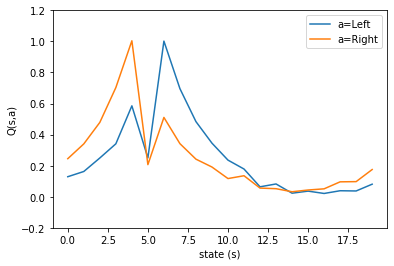

In [23]:
plt.plot(Q_full[:,0])
plt.plot(Q_full[:,1])
plt.ylim([-0.2,1.2])
plt.ylabel('Q(s,a)')
plt.xlabel('state (s)')
plt.legend(['a=Left','a=Right'],loc='upper right')
plt.show()

### Partially-Observable Task

In [24]:
class POMaze1D():
    def __init__(self,
                 n_states=10,
                 n_tasks=2,
                 goal_states=[3,7],
                 reward_nongoal=0.0,
                 reward_goal=1.0):
        """
        These options are paricular to the 1D maze environment/task:
        n_states - size (length) of the 1D maze
        n_tasks - number of unique tasks
        goal_states - where the tasks terminate (terminal states)
        reward_nongoal - scalar reward for all non-terminal states
        reward_goal - scalar reward for terminal state
        """
        self.n_states = n_states
        self.n_tasks = n_tasks
        self.goal_states = goal_states
        self.reward_nongoal = reward_nongoal
        self.reward_goal = reward_goal
        # Agent's current location and context (initially nowhere)
        self.x = np.array([-1,-1])
        # Agent's initial task (initially no task)
        self.t = np.array([-1])
        self.observation_space = np.array([n_states,n_tasks+1])
        class a: pass
        self.action_space = a()
        self.action_space.n = 2
        
    def reset(self):
        self.t[0] = np.random.randint(self.n_tasks)
        self.x[1] = self.t[0]+1
        self.x[0] = np.random.randint(self.n_states)
        while self.x[0] == self.goal_states[self.t[0]]:
            self.x[0] = np.random.randint(self.n_states)
        return np.copy(self.x)
    
    def step(self,action):
        if action:
            self.x[0] = (self.x[0] + 1) % self.n_states
            self.x[1] = 0
        else:
            self.x[0] = (self.x[0] - 1) % self.n_states
            self.x[1] = 0
        if self.x[0] == self.goal_states[self.t[0]]:
            r = self.reward_goal
            d = True
        else:
            r = self.reward_nongoal
            d = False
        return np.copy(self.x), r, d, None

In [115]:
n_states = 20
n_tasks = 2
goal_states = [5,15]
env = POMaze1D(n_states=n_states,
               n_tasks=n_tasks,
               goal_states=goal_states)

In [26]:
env.observation_space

array([20,  3])

In [27]:
env.action_space.n

2

In [113]:
observation = env.reset()
print(observation)
for time in range(5):
    observation, reward, done, info = env.step(0) # take action!
    print(observation,reward,done,info)

[1 1]
[0 0] 0.0 False None
[19  0] 0.0 False None
[18  0] 0.0 False None
[17  0] 0.0 False None
[16  0] 0.0 False None


### Don't Change!

In [116]:
def circ_conv(x,y=None):
    if y is not None:
        tf.math.real(tf.signal.ifft(tf.signal.fft(x)*tf.signal.fft(y)))
    else:
        return tf.math.real(tf.signal.ifft(tf.reduce_prod(tf.signal.fft(tf.cast(x,tf.complex64)),axis=1)))    

In [236]:
def circ_pow(x,y=0.0):
    return tf.math.real(tf.signal.ifft(tf.pow(tf.signal.fft(tf.cast(x,tf.complex64)),tf.cast(y,tf.complex64))))

### Standard RL Model Applied to PO Task...

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_80 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 lambda_106 (Lambda)            (None, 1)            0           ['input_80[0][0]']               
                                                                                                  
 lambda_107 (Lambda)            (None, 1)            0           ['input_80[0][0]']               
                                                                                                  
 embedding_79 (Embedding)       (None, 1, 100)       2000        ['lambda_106[0][0]']             
                                                                                           

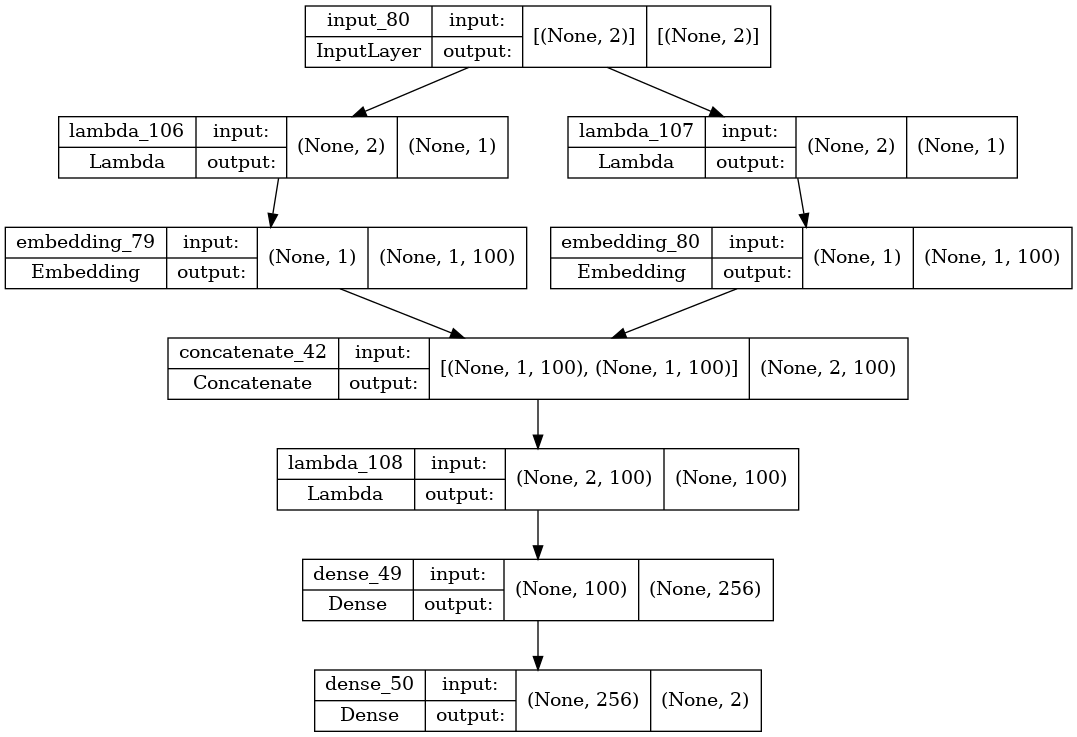

In [164]:
# A simple multilayer architecture....
def make_model(state_shape,
               action_shape,
               state_length = 10,
               context_length = 3,
               embedding_dim = 100,
               hidden_dim = 256):
    """
    The state_shape and action_shape are typical parameters
    that are obtained from the OpenAI gym framework - usually one
    would utilize the env.observation_space.shape and
    env.action_space.n for most situations to set these values,
    respectively.
    
    The remaining keyword arguments are problem-specific and
    may need to be rewritten based on your model architecture.
    For example, here we are using a -discrete- input space for
    the 1DMaze problem - so the input shape is (1,) which can
    be obtained from the variables above for setting state_shape
    appropriately, but the Embedding of those discrete tokens
    (i.e. 0, 1, 2, 3, ..., (n-1)) for each state needs to know
    the maximum number of states (and therefore random vectors)
    to expect in that input vector.
    """
    x = keras.layers.Input(state_shape)
    y = x
    
    y1 = keras.layers.Lambda(lambda x: x[:,0:1])(y)
    y1 = keras.layers.Embedding(input_dim=state_length,
                               output_dim=embedding_dim)(y1)
    y2 = keras.layers.Lambda(lambda x: x[:,1:2])(y)
    y2 = keras.layers.Embedding(input_dim=context_length,
                               output_dim=embedding_dim)(y2)

    y = keras.layers.Concatenate(1)([y1,y2])
    y = keras.layers.Lambda(circ_conv)(y)
    # y = keras.layers.Concatenate()([y1,y2])
    # y = keras.layers.Flatten()(y)

    y = keras.layers.Dense(hidden_dim,activation='gelu')(y)
    y = keras.layers.Dense(action_shape)(y)
    model = keras.Model(x,y)
    model.compile(loss=keras.losses.MeanSquaredError(),
                  optimizer=keras.optimizers.SGD(learning_rate=0.001))
    return model

model = make_model(env.observation_space.shape[0],env.action_space.n,
                   state_length=env.observation_space[0],
                   context_length=env.observation_space[1])
model.summary()
keras.utils.plot_model(model,show_shapes=True)

In [129]:
Q = model(np.array([[0,0]]))
Q

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.00869754,  0.00457796]], dtype=float32)>

In [130]:
Q.numpy().argmax()

1

In [131]:
# epsilon-greedy policy
epsilon = 0.1
action = np.random.choice([0,1]) if np.random.random() < epsilon else Q.numpy().argmax()
action

1

In [132]:
Q.numpy()

array([[-0.00869754,  0.00457796]], dtype=float32)

In [133]:
# Initialize the environment and let the agent decide!
observation = env.reset()
trace = []
epsilon = 0.1
reward = 0.0
for time in range(30):
    Q = model(np.expand_dims(observation,axis=0)) # Compute Q
    action = np.random.choice([0,1]) if np.random.random() < epsilon else Q.numpy().argmax()
    trace.append(np.concatenate([observation,[action],Q[0]]))
    observation, reward, done, info = env.step(action) # take action!
    if (done):
        break
trace.append(np.concatenate([observation,[action],Q[0]]))
# s, a, Q(s,L), Q(s,R)
print(np.vstack(trace))

[[ 6.00000000e+00  2.00000000e+00  0.00000000e+00  2.77655683e-02
  -1.07148942e-02]
 [ 5.00000000e+00  0.00000000e+00  1.00000000e+00  2.00461820e-02
   4.32745032e-02]
 [ 6.00000000e+00  0.00000000e+00  1.00000000e+00  1.94805209e-02
   2.09221356e-02]
 [ 7.00000000e+00  0.00000000e+00  1.00000000e+00  1.09864743e-02
   1.62206590e-02]
 [ 8.00000000e+00  0.00000000e+00  1.00000000e+00 -8.88565555e-03
   2.67938077e-02]
 [ 9.00000000e+00  0.00000000e+00  1.00000000e+00  3.58566549e-03
   5.66580519e-02]
 [ 1.00000000e+01  0.00000000e+00  1.00000000e+00 -1.86403431e-02
   3.48661877e-02]
 [ 1.10000000e+01  0.00000000e+00  0.00000000e+00  1.44062992e-02
   2.38661980e-03]
 [ 1.00000000e+01  0.00000000e+00  1.00000000e+00 -1.86403431e-02
   3.48661877e-02]
 [ 1.10000000e+01  0.00000000e+00  0.00000000e+00  1.44062992e-02
   2.38661980e-03]
 [ 1.00000000e+01  0.00000000e+00  1.00000000e+00 -1.86403431e-02
   3.48661877e-02]
 [ 1.10000000e+01  0.00000000e+00  0.00000000e+00  1.44062992e-02

In [134]:
# Step 1 - Replay Memory Class
class ReplayMemory:
    def __init__(self, memory_size, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.size = 0
        self.maxsize = memory_size
        self.current_index = 0
        self.current_state = np.zeros([memory_size,env.observation_space.shape[0]])
        self.action = [0]*memory_size # Remember, actions are integers...
        self.reward = np.zeros([memory_size])
        self.next_state = np.zeros([memory_size,env.observation_space.shape[0]])
        self.done = [False]*memory_size # Boolean (terminal transition?)

    def remember(self, current_state, action, reward, next_state, done):
        # Stores a single memory item
        self.current_state[self.current_index,:] = current_state
        self.action[self.current_index] = action
        self.reward[self.current_index] = reward
        self.next_state[self.current_index,:] = next_state
        self.done[self.current_index] = done
        self.current_index = (self.current_index+1)%self.maxsize
        self.size = max(self.current_index,self.size)
    
    def replay(self, model, target_model, num_samples, sample_size, gamma):
        # Run replay!
        
        # Can't train if we don't yet have enough samples to begin with...
        if self.size < sample_size:
            return
        
        for i in range(num_samples):
            # Select sample_size memory indices from the whole set
            current_sample = np.random.choice(self.size,sample_size,replace=False)
            
            # Slice memory into training sample
            current_state = self.current_state[current_sample,:]
            action = [self.action[j] for j in current_sample]
            reward = self.reward[current_sample]
            next_state = self.next_state[current_sample,:]
            done = [self.done[j] for j in current_sample]
            
            # Obtain model's current Q-values
            model_targets = model(current_state).numpy()
            
            # Create targets from argmax(Q(s+1,a+1))
            # Use the target model!
            targets = reward + gamma*np.amax(target_model(next_state).numpy(),axis=1)
            # Absorb the reward on terminal state-action transitions
            targets[done] = reward[done]
            # Update just the relevant parts of the model_target vector...
            model_targets[range(sample_size),action] = targets
            
            # Update the weights accordingly
            model.train_on_batch(current_state,model_targets)
            # model.fit(current_state,model_targets,
            #          epochs=1,verbose=0,batch_size=sample_size)
            
        # Once we have finished training, update the target model
        target_model.set_weights(model.get_weights())

In [135]:
# Full setup for the task...

# For keeping track of performance
from collections import deque

# Hyperparameters
gamma = 0.7
epsilon = 1.0
epsilon_decay = 0.98
epsilon_min = 0.01
episodes = 1000

# Total memory size (number of actions remembered...)
n_memories = 1000

# How many batches do we want to train on
# from the memory before updating the
# target model?
replay_iterations = 10

# How many memories do we use in each batch?
replay_sample_size = 50

# Peformance stats
times_window = deque(maxlen=100)
mean_times = deque(maxlen=episodes)

# Initialize the environment and agent data structures
# env = gym.make('CartPole-v1')
model = make_model(env.observation_space.shape[0],env.action_space.n,
                   state_length=env.observation_space[0])
target_model = make_model(env.observation_space.shape[0],env.action_space.n,
                          state_length=env.observation_space[0])
memory = ReplayMemory(n_memories,env.observation_space.shape[0],env.action_space.n)

In [136]:
np.any(memory.current_state[:,1]==1)

False

In [137]:
memory.current_state[0:10]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [138]:
memory.next_state[0:10]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [139]:
memory.action[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [140]:
memory.reward[0:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [141]:
memory.done[0:10]

[False, False, False, False, False, False, False, False, False, False]

In [142]:
np.any(memory.done)

False

In [143]:
current_state = env.reset()
current_state

array([17,  1])

In [144]:
env.step(1)

(array([18,  0]), 0.0, False, None)

In [145]:
# Perform the training!
for episode in range(episodes):
    current_state = env.reset()
    for time in range(env.observation_space[0]):
        Q = model(np.expand_dims(current_state,axis=0))
        action = np.random.choice(env.action_space.n) if np.random.random() < epsilon else np.argmax(Q)
        next_state, reward, done, info = env.step(action) # take action!
        memory.remember(current_state,action,reward,next_state,done) # Store in memory...
        current_state = next_state # Transition to next state!
        if (done):
            break
    epsilon = epsilon * epsilon_decay if epsilon > epsilon_min else epsilon_min
    times_window.append(time)
    mean_time = np.mean(times_window)
    mean_times.append(mean_time)
    print('\rEpisode %d/%d - time: %d, mean-time: %d, epsilon: %f'%(episode+1,episodes,time,mean_time,epsilon),end='')

    # Training...
    if (episode+1) % 20 == 0:
        memory.replay(model,target_model,replay_iterations,replay_sample_size,gamma)
print()

Episode 1000/1000 - time: 19, mean-time: 17, epsilon: 0.010000


In [146]:
Q_full = []
for i in range(n_tasks+1):
    Q_full.append(model(np.vstack([np.arange(env.observation_space[0]),[i]*env.observation_space[0]]).T).numpy())

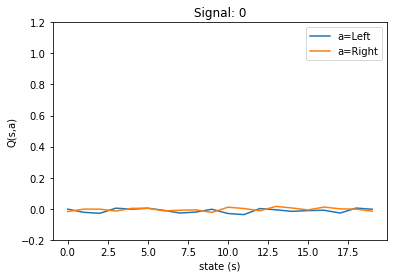

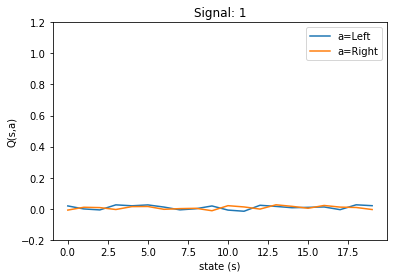

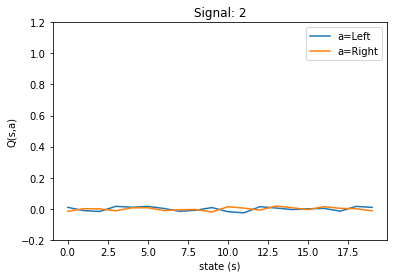

In [147]:
for i in range(n_tasks+1):
    plt.plot(Q_full[i][:,0])
    plt.plot(Q_full[i][:,1])
    plt.ylim([-0.2,1.2])
    plt.ylabel('Q(s,a)')
    plt.xlabel('state (s)')
    plt.title('Signal: %d'%(i))
    plt.legend(['a=Left','a=Right'],loc='upper right')
    plt.show()